<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
### imports apps (specialized functions)

In [ ]:
P = pd.read_csv("processed_df.csv", parse_dates=[0], index_col=0)

In [2]:
#add another feature
rolling_win = 261
def calc_z_score(x):
    return (x[-1]-x.mean())/x.std(ddof=0)
P["Rolling Z"] = P["Crude oil spot USD per barrel (Brent)"].rolling(rolling_win).apply(calc_z_score)
P = P.iloc[rolling_win:,]
P

C:\Users\mrche\AppData\Local\Temp\ipykernel_48428\4247913113.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (x[-1]-x.mean())/x.std(ddof=0)


,Crude oil spot USD per barrel (Brent),Crude oil spot USD per barrel (WTI),"China crude oil import monthly total (10,000USD)",Crude oil stockpile OECD,Crude oil stockpile worldwide,LSFO non-commercial Long Volume,LSFO non-commercial Short Volume,LSFO Total Volume,S&P 500,Dow Jones Industrial,...,NASDAQ Composite,CPI_U,CPI_ENERGY,PPI_MANUFACTURING,PPI_MINING,USD_EURO_EXCHANGE_RATE,USD index,Euro to USD,LME 3 month Copper futures USD per ton,Rolling Z
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-23,98.45,112.235,1843037.5,1351.169,1351.0,456968.0,110268.0,1629694.0,1818.319946,16221.139648,...,4104.740234,234.719,245.733,193.200,235.200,1.3673,80.5500,1.36700,7235.75,0.095141
2013-12-24,98.81,111.660,1843037.5,1351.169,1351.0,456968.0,110268.0,1629694.0,1827.989990,16294.610352,...,4148.899902,234.719,245.733,193.200,235.200,1.3701,80.4300,1.36940,7241.00,0.157067
2013-12-25,98.81,111.100,1843037.5,1351.169,1351.0,458206.0,105441.0,1598935.0,1833.319946,16357.549805,...,4155.419922,234.719,245.733,193.200,235.200,1.3676,80.5200,1.36710,7241.00,0.153081
2013-12-26,99.61,111.100,1843037.5,1351.169,1351.0,458206.0,105441.0,1598935.0,1833.319946,16357.549805,...,4155.419922,234.719,245.733,193.200,235.200,1.3676,80.5300,1.36790,7241.00,0.295668
2013-12-27,100.19,111.100,1843037.5,1351.169,1351.0,458206.0,105441.0,1598935.0,1842.020020,16479.880859,...,4167.180176,234.719,245.733,193.200,235.200,1.3690,80.5000,1.36900,7241.00,0.397808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-21,77.77,83.610,3235356.0,907.000,907.0,364379.0,148645.0,1639133.0,4547.379883,35151.039062,...,14284.530273,307.619,286.877,249.088,232.823,1.0945,103.4892,1.09399,8447.50,-0.060461
2023-11-22,77.10,82.250,3235356.0,907.000,907.0,350785.0,143461.0,1553677.0,4538.189941,35088.289062,...,14199.980469,307.619,286.877,249.088,232.823,1.0923,103.6092,1.09108,8470.00,-0.165802
2023-11-23,76.40,79.630,3235356.0,907.000,907.0,350785.0,143461.0,1553677.0,4556.620117,35273.031250,...,14265.860352,307.619,286.877,249.088,232.823,1.0871,103.8731,1.08888,8376.50,-0.275050


<AxesSubplot:xlabel='Date'>

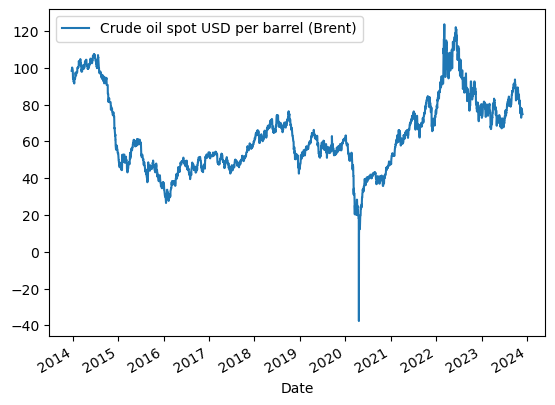

In [3]:
P[["Crude oil spot USD per barrel (Brent)"]].astype(float).plot()

In [4]:
P_c=P.copy()
P=P_c.astype(float)

In [5]:
#train-test split
train_test_split_ratio = 0.75
train_val_split_ratio=0.1

train_test_split_index = int(train_test_split_ratio*P.shape[0])
print("train_test_split_index", train_test_split_index)

start_of_val_index=train_test_split_index-int(train_val_split_ratio*P.shape[0])
end_of_val_index=train_test_split_index

print("start_of_val_index", start_of_val_index)
print("end_of_val_index", end_of_val_index)

train_test_split_index 2177
start_of_val_index 1887
end_of_val_index 2177


In [6]:
print(start_of_val_index/len(P))
print(end_of_val_index/len(P))
print(train_test_split_index/len(P))

0.6500172235618326
0.7499138821908371
0.7499138821908371


In [7]:
P.index[start_of_val_index]

Timestamp('2020-09-09 00:00:00')

In [8]:
P.index[end_of_val_index]

Timestamp('2021-08-10 00:00:00')

In [9]:
#scaling
from sklearn.preprocessing import MinMaxScaler
scalerX = MinMaxScaler(feature_range=(-1, 1))
scalerY = MinMaxScaler(feature_range=(-1, 1))
# scalerYt = MinMaxScaler(feature_range=(-1, 1))

trainX_scaled = scalerX.fit_transform(P.iloc[   :train_test_split_index,1:].values)
testX_scaled = scalerX.transform(P.iloc[train_test_split_index:   ,1:].values)
print(trainX_scaled.shape,testX_scaled.shape)

trainY_scaled = scalerY.fit_transform(P.iloc[   :train_test_split_index,0].values.reshape(-1, 1))
testY_scaled = scalerY.transform(P.iloc[train_test_split_index:   ,0].values.reshape(-1, 1))
print(trainY_scaled.shape,testY_scaled.shape)

(2177, 21) (726, 21)
(2177, 1) (726, 1)


In [10]:
#combined the scaled trainX and testX, because I dont want gaps between train_seq and test_seq

combined_X_scaled=np.concatenate((trainX_scaled, testX_scaled), axis=0)
print("combined_X_scaled.shape", combined_X_scaled.shape)
combined_Y_scaled=np.concatenate((trainY_scaled, testY_scaled), axis=0)
print("combined_Y_scaled.shape", combined_Y_scaled.shape)

recombined_P=np.concatenate((combined_Y_scaled,combined_X_scaled), axis=1)
print("recombined_P.shape", recombined_P.shape)

recomb_P_df=pd.DataFrame(data=recombined_P,
                        index=P.index,
                        columns=P.columns)
recomb_P_df

combined_X_scaled.shape (2903, 21)
combined_Y_scaled.shape (2903, 1)
recombined_P.shape (2903, 22)


,Crude oil spot USD per barrel (Brent),Crude oil spot USD per barrel (WTI),"China crude oil import monthly total (10,000USD)",Crude oil stockpile OECD,Crude oil stockpile worldwide,LSFO non-commercial Long Volume,LSFO non-commercial Short Volume,LSFO Total Volume,S&P 500,Dow Jones Industrial,...,NASDAQ Composite,CPI_U,CPI_ENERGY,PPI_MANUFACTURING,PPI_MINING,USD_EURO_EXCHANGE_RATE,USD index,Euro to USD,LME 3 month Copper futures USD per ton,Rolling Z
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-23,0.874897,0.939914,0.317611,1.000000,1.000000,-0.757862,-0.731693,-0.631678,-0.943272,-0.914463,...,-0.980220,-1.000000,0.875384,-0.299754,0.666909,0.856982,-0.884075,0.851622,-0.065805,0.425379
2013-12-24,0.879857,0.928641,0.317611,1.000000,1.000000,-0.757862,-0.731693,-0.631678,-0.936095,-0.907055,...,-0.972116,-1.000000,0.875384,-0.299754,0.666909,0.872748,-0.894011,0.865162,-0.064120,0.437844
2013-12-25,0.879857,0.917663,0.317611,1.000000,1.000000,-0.752542,-0.765306,-0.678289,-0.932139,-0.900709,...,-0.970920,-1.000000,0.875384,-0.299754,0.666909,0.858671,-0.886559,0.852186,-0.064120,0.437041
2013-12-26,0.890879,0.917663,0.317611,1.000000,1.000000,-0.752542,-0.765306,-0.678289,-0.932139,-0.900709,...,-0.970920,-1.000000,0.875384,-0.299754,0.666909,0.858671,-0.885731,0.856700,-0.064120,0.465741
2013-12-27,0.898870,0.917663,0.317611,1.000000,1.000000,-0.752542,-0.765306,-0.678289,-0.925682,-0.888375,...,-0.968762,-1.000000,0.875384,-0.299754,0.666909,0.866554,-0.888215,0.862906,-0.064120,0.486299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-21,0.589970,0.378749,1.976754,-0.830987,-0.830928,-1.155742,-0.464459,-0.617375,1.082282,0.994205,...,0.887946,2.821656,1.988301,2.399237,0.632335,-0.679054,1.015377,-0.688632,0.323168,0.394060
2023-11-22,0.580738,0.352088,1.976754,-0.830987,-0.830928,-1.214159,-0.500557,-0.746871,1.075461,0.987878,...,0.872430,2.821656,1.988301,2.399237,0.632335,-0.691441,1.025313,-0.705049,0.330391,0.372857
2023-11-23,0.571094,0.300725,1.976754,-0.830987,-0.830928,-1.214159,-0.500557,-0.746871,1.089140,1.006505,...,0.884520,2.821656,1.988301,2.399237,0.632335,-0.720721,1.047165,-0.717461,0.300377,0.350868


In [11]:
recomb_P_df.describe()

,Crude oil spot USD per barrel (Brent),Crude oil spot USD per barrel (WTI),"China crude oil import monthly total (10,000USD)",Crude oil stockpile OECD,Crude oil stockpile worldwide,LSFO non-commercial Long Volume,LSFO non-commercial Short Volume,LSFO Total Volume,S&P 500,Dow Jones Industrial,...,NASDAQ Composite,CPI_U,CPI_ENERGY,PPI_MANUFACTURING,PPI_MINING,USD_EURO_EXCHANGE_RATE,USD index,Euro to USD,LME 3 month Copper futures USD per ton,Rolling Z
count,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,...,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000,2903.000000
mean,0.400101,0.082219,0.367660,-0.103167,-0.102856,-0.392445,-0.399757,-0.121904,-0.031717,0.036108,...,-0.131360,0.330722,0.454250,0.316999,0.074875,-0.409208,0.396979,-0.415410,-0.162473,0.413681
std,0.283692,0.435961,0.800342,0.484389,0.484554,0.544238,0.408280,0.464463,0.665200,0.657698,...,0.650487,1.169926,0.988879,1.167264,0.624345,0.456213,0.526018,0.456956,0.493725,0.293322
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.476859,-1.036920,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.427365,-1.000000,-1.448237,-1.000000,-1.000000
25%,0.188895,-0.252696,-0.321859,-0.505327,-0.505155,-0.712285,-0.722091,-0.520343,-0.688581,-0.702897,...,-0.775910,-0.661503,-0.293282,-0.507413,-0.348364,-0.697072,0.152719,-0.704654,-0.519942,0.221537
50%,0.344861,0.025681,0.347209,-0.163178,-0.162887,-0.448970,-0.464076,-0.057174,-0.176830,0.042276,...,-0.291638,0.071532,0.139723,-0.145217,-0.136000,-0.500563,0.423570,-0.508039,-0.263783,0.416582
75%,0.584459,0.357675,0.828278,0.244927,0.245361,0.054257,-0.199390,0.193013,0.627132,0.717872,...,0.449469,1.000000,0.988775,1.000000,0.548975,-0.196791,0.658836,-0.205642,0.220929,0.647438
max,1.222789,1.439326,2.319354,1.000000,1.000000,1.000000,1.000000,1.000000,1.267228,1.160432,...,1.213306,2.821656,3.109820,3.042981,1.984247,1.000000,1.898926,1.000000,1.014124,1.357798


In [12]:
#create sequence
def create_sequence(data, n_steps):
    X_seq=[]
    y_seq=[]
    for i in range(n_steps,len(data)):
        X_seq.append(data.iloc[i-n_steps:i, 1:])
        y_seq.append(data.iloc[i-1, 0])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq) 
    return X_seq, y_seq

n_steps=2
X_seq, y_seq=create_sequence(recomb_P_df, n_steps)
X_seq.shape, y_seq.shape

((2901, 2, 21), (2901,))

In [13]:
y_seq=y_seq.reshape(-1, 1)
y_seq.shape

(2901, 1)

In [14]:
# split sequence into train, val, test for both X and Y
trainX_seq = X_seq[          :start_of_val_index                        ,:,:]
print("trainX_seq.shape", trainX_seq.shape)
valX_seq = X_seq[             start_of_val_index:train_test_split_index ,:,:]
print("valX_seq.shape", valX_seq.shape)
testX_seq = X_seq[                               train_test_split_index:,:,:]
print("testX_seq.shape", testX_seq.shape)

trainY_seq = y_seq[:start_of_val_index]
print("\ntrainY_seq.shape", trainY_seq.shape)
valY_seq = y_seq[start_of_val_index:train_test_split_index]
print("valY_seq.shape", valY_seq.shape)
testY_seq = y_seq[train_test_split_index:]
print("testY_seq.shape", testY_seq.shape)

trainX_seq.shape (1887, 2, 21)
valX_seq.shape (290, 2, 21)
testX_seq.shape (724, 2, 21)

trainY_seq.shape (1887, 1)
valY_seq.shape (290, 1)
testY_seq.shape (724, 1)


In [15]:
##for performance & plotting

train_valX_seq=np.concatenate((trainX_seq, valX_seq), axis=0)
print("train_valX_seq.shape", train_valX_seq.shape)

train_valY_seq=np.concatenate((trainY_seq, valY_seq), axis=0)
print("train_valY_seq.shape", train_valY_seq.shape)

train_valX_seq.shape (2177, 2, 21)
train_valY_seq.shape (2177, 1)


Model creation

In [16]:
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras import callbacks
from keras.regularizers import l1_l2
from tensorflow.keras.regularizers import l1


dropout_rate = 0.1
loss_func = "mean_squared_error"    
batch_size = 32
n_epochs = 500
n_earlystop = 50
# validation_rate = 0.05

model=Sequential()
model.add(LSTM(units=512,return_sequences=True,input_shape=(trainX_seq.shape[1],trainX_seq.shape[2]), kernel_regularizer=l1_l2(l1=0.01, l2=0.015)))
model.add(Dropout(dropout_rate))
model.add(LSTM(units=256,return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(dropout_rate))
# model.add(LSTM(units=64,return_sequences=True))
# model.add(Dropout(dropout_rate))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss=loss_func)

earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=n_earlystop, restore_best_weights=True)
history = model.fit(trainX_seq, trainY_seq, validation_data=(valX_seq, valY_seq), epochs=n_epochs, batch_size=batch_size, verbose=1, callbacks =[earlystopping])



Epoch 1/500

59/59 [==============================] - 4s 26ms/step - loss: 4.0499 - val_loss: 0.3223
Epoch 2/500
59/59 [==============================] - 1s 13ms/step - loss: 0.1320 - val_loss: 0.0688
Epoch 3/500
59/59 [==============================] - 1s 13ms/step - loss: 0.0708 - val_loss: 0.0640
Epoch 4/500
59/59 [==============================] - 1s 13ms/step - loss: 0.0639 - val_loss: 0.0591
Epoch 5/500
59/59 [==============================] - 1s 13ms/step - loss: 0.0610 - val_loss: 0.0624
Epoch 6/500
59/59 [==============================] - 1s 13ms/step - loss: 0.0611 - val_loss: 0.0584
Epoch 7/500
59/59 [==============================] - 1s 13ms/step - loss: 0.0594 - val_loss: 0.0582
Epoch 8/500
59/59 [==============================] - 1s 13ms/step - loss: 0.0589 - val_loss: 0.0622
Epoch 9/500
59/59 [==============================] - 1s 14ms/step - loss: 0.0586 - val_loss: 0.0575
Epoch 10/500
59/59 [==============================] - 1s 14ms/step - loss: 0.0580 - val_loss: 0.0

In [17]:
model.save('logerr_sequence_validation_step2.keras')

In [18]:
# model=keras.models.load_model('logerr_sequence_validation.keras')

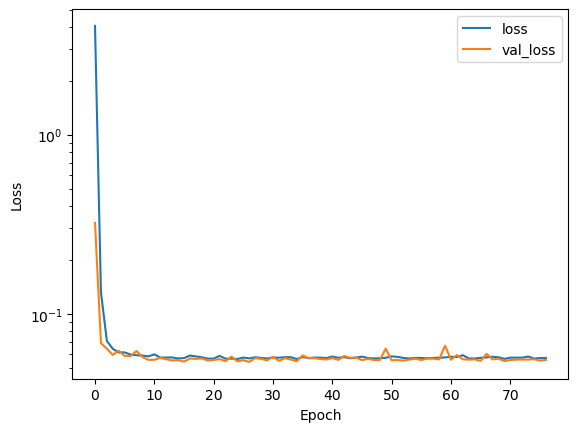

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig()
plt.show()


In [20]:
model.summary()

# train_valY_seq
# testY_seq

pred_train_valY=model.predict(train_valX_seq)[:,0]
pred_test_y=model.predict(testX_seq)[:,0]

import math
from sklearn.metrics import mean_squared_error, r2_score

train_rmse=math.sqrt(mean_squared_error(train_valY_seq,pred_train_valY))
test_rmse=math.sqrt(mean_squared_error(testY_seq,pred_test_y))

train_r2=r2_score(train_valY_seq, pred_train_valY)
test_r2=r2_score(testY_seq, pred_test_y)
print(f'Train:\n- RMSE: {train_rmse}\n- R2: {train_r2}')
print(f'Test:\n- RMSE: {test_rmse}\n- R2: {test_r2}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 512)            1093632   
                                                                 
 dropout (Dropout)           (None, 2, 512)            0         
                                                                 
 lstm_1 (LSTM)               (None, 2, 256)            787456    
                                                                 
 dropout_1 (Dropout)         (None, 2, 256)            0         
                                                                 
 lstm_2 (LSTM)               (None, 2, 128)            197120    
                                                                 
 dropout_2 (Dropout)         (None, 2, 128)            0         
                                                                 
 dense (Dense)               (None, 2, 1)              1

In [21]:
trainY=trainY_scaled
testY=testY_scaled
predict_train=pred_train_valY
predict_test=pred_test_y

In [22]:
def plot_result(trainY, testY, predict_train, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(predict_train, test_predict)
    dates = P.index[-len(actual):]
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(dates, actual)
    plt.plot(dates, predictions)
    plt.axvline(x=P.index[trainY_seq.shape[0]], color='b', linestyle='--')
    plt.axvline(x=P.index[len(trainY)], color='r', linestyle='--')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Date')
    plt.ylabel('US$/Barrel')
    plt.title('Crude Oil Price Prediction using LSTM Model')
    plt.savefig('LSTM_step2.png')

    plt.show()

    return pd.DataFrame({"Actual":actual, "Prediction":predictions})

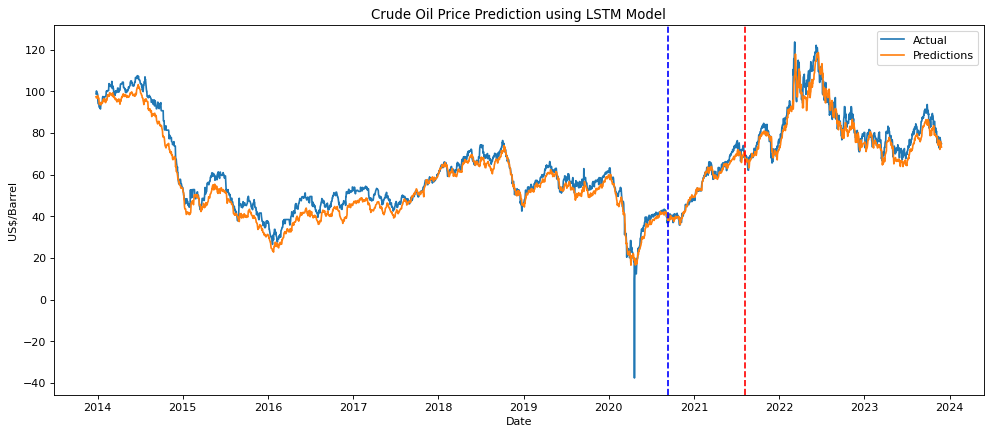

In [23]:
trainY1 = scalerY.inverse_transform(trainY)
testY1 = scalerY.inverse_transform(testY)
train_predict1 = scalerY.inverse_transform(predict_train)
test_predict1 = scalerY.inverse_transform(pred_test_y)

result_df = plot_result(trainY1[n_steps:,0], testY1, train_predict1, test_predict1)

In [24]:
result_df

,Actual,Prediction
0,98.81,97.424667
1,99.61,97.166977
2,100.19,96.825409
3,99.25,96.922737
4,98.66,97.024147
...,...,...
2896,77.77,73.548805
2897,77.10,73.742027
2898,76.40,75.925179
2899,75.54,75.021469


In [25]:
result_df.index = P.index[-result_df.shape[0]:]
result_df.to_csv("LSTM_step2.csv")